In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.set_option("mode.copy_on_write", True)

# Load merged dataset
url = r"C:\Users\sejal\Dropbox\PC\Downloads\threshold.csv"
final_merged_data = pd.read_csv(url)

# Quick checks
print(final_merged_data.shape)
print(final_merged_data.head())
print(final_merged_data.columns)

# Ensure county code / FIPS are string to preserve leading zeros
if "County Code" in final_merged_data.columns:
    final_merged_data["County Code"] = final_merged_data["County Code"].astype(str).str.zfill(5)


(55865, 10)
  Buyer State Buyer County      Total_MME              County  County Code  \
0          GA       BARTOW   26880.045346   Bartow County, GA        13015   
1          GA         BIBB   45120.212068     Bibb County, GA        13021   
2          GA      CARROLL   30212.695235  Carroll County, GA        13045   
3          GA      CATOOSA   72586.128925  Catoosa County, GA        13047   
4          GA      CHATHAM  530712.069977  Chatham County, GA        13051   

                          Drug/Alcohol Induced Cause  \
0  Drug poisonings (overdose) Unintentional (X40-...   
1  Drug poisonings (overdose) Unintentional (X40-...   
2  Drug poisonings (overdose) Unintentional (X40-...   
3  Drug poisonings (overdose) Unintentional (X40-...   
4  Drug poisonings (overdose) Unintentional (X40-...   

  Drug/Alcohol Induced Cause Code  Deaths  Year  Population  
0                              D1      18  2015      102043  
1                              D1      14  2015      15394

In [70]:
final_merged_data.groupby("Buyer State")["Total_MME"].sum().sort_values()


Buyer State
MT    3.622566e+06
ID    8.377413e+06
SC    8.248198e+07
WA    2.221444e+08
OR    1.680088e+10
NC    1.589893e+11
GA    4.957049e+11
FL    5.555237e+12
Name: Total_MME, dtype: float64

In [73]:
final_merged_data.groupby("Buyer State")["Year"].unique()


Buyer State
FL    [2015, 2007, 2009, 2010, 2011, 2012, 2013, 201...
GA    [2015, 2006, 2008, 2010, 2012, 2014, 2011, 200...
ID    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...
MT    [2008, 2013, 2007, 2012, 2014, 2009, 2010, 200...
NC    [2015, 2006, 2007, 2008, 2009, 2011, 2012, 201...
OR    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
SC    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
WA    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
Name: Year, dtype: object

In [74]:
final_merged_data["opioid_per_capita_test"] = (
    final_merged_data["Total_MME"] / final_merged_data["Population"]
)

final_merged_data.groupby("Buyer State")["opioid_per_capita_test"].mean()


Buyer State
FL    130.883990
GA    273.365416
ID      0.198802
MT      0.253933
NC     58.364493
OR     33.818468
SC      0.153400
WA      0.065850
Name: opioid_per_capita_test, dtype: float64

In [75]:
final_merged_data[
    (final_merged_data["Buyer State"] == "WA") &
    (final_merged_data["Year"].between(2006, 2011))
][["Buyer State", "Year", "Total_MME", "Population"]].head(20)


,Buyer State,Year,Total_MME,Population
1724,WA,2006,1249.017754,159564
1725,WA,2007,1640.148150,161669
1726,WA,2008,1684.535868,166573
1727,WA,2009,1983.315852,171122
1728,WA,2010,2023.409735,176455
1729,WA,2010,2023.409735,176465
1730,WA,2011,2606.102704,180436
1735,WA,2010,761.906822,72735
1736,WA,2010,761.906822,72750
1737,WA,2011,594.885423,73214


In [76]:
# States for WA policy
states_to_check = ["WA", "OR", "ID", "MT"]

# Build clean panel for 2006–2011
panel = final_merged_data[
    (final_merged_data["Buyer State"].isin(states_to_check)) &
    (final_merged_data["Year"].between(2006, 2011))
][[
    "Buyer State", "County Code", "Year", "Population", "Total_MME"
]].copy()

# Compute opioid per capita (correct)
panel["opioid_per_capita"] = panel["Total_MME"] / panel["Population"]


In [77]:
# Check for missing values in key variables
panel

,Buyer State,County Code,Year,Population,Total_MME,opioid_per_capita
1167,MT,30013,2008,80529,1344.293673,0.016693
1169,MT,30029,2007,88245,2982.712679,0.033800
1170,MT,30029,2008,90260,3513.380093,0.038925
1174,MT,30031,2009,89187,896.318437,0.010050
1176,MT,30063,2008,107747,1692.482990,0.015708
...,...,...,...,...,...,...
55856,ID,16027,2010,189347,28760.966993,0.151896
55857,ID,16027,2011,191354,35322.864391,0.184594
55860,ID,16055,2006,129510,28703.340115,0.221630
55861,ID,16055,2008,135627,31144.131172,0.229631


In [78]:
panel.columns

Index(['Buyer State', 'County Code', 'Year', 'Population', 'Total_MME',
       'opioid_per_capita'],
      dtype='object')

In [79]:
panel.head()

,Buyer State,County Code,Year,Population,Total_MME,opioid_per_capita
1167,MT,30013,2008,80529,1344.293673,0.016693
1169,MT,30029,2007,88245,2982.712679,0.033800
1170,MT,30029,2008,90260,3513.380093,0.038925
1174,MT,30031,2009,89187,896.318437,0.010050
1176,MT,30063,2008,107747,1692.482990,0.015708


In [80]:
panel.isna().sum()

Buyer State          0
County Code          0
Year                 0
Population           0
Total_MME            0
opioid_per_capita    0
dtype: int64

In [83]:
panel.groupby("Buyer State").size()

Buyer State
ID     115
MT      70
OR     923
WA    3042
dtype: int64

In [84]:
# Ensure numeric values before computing per capita rates
panel["Population"] = pd.to_numeric(panel["Population"], errors="coerce")
panel["Total_MME"] = pd.to_numeric(panel["Total_MME"], errors="coerce")

# Recompute opioid_per_capita after coercion
panel["opioid_per_capita"] = panel["Total_MME"] / panel["Population"]


In [86]:
# Treated indicator: Washington = 1, control states = 0
panel["treated"] = (panel["Buyer State"] == "WA").astype(int)

In [87]:
panel.groupby("Buyer State")["treated"].mean()

Buyer State
ID    0.0
MT    0.0
OR    0.0
WA    1.0
Name: treated, dtype: float64

### Parallel Trend Plot for Opioid Per Capita (WA vs Controls)

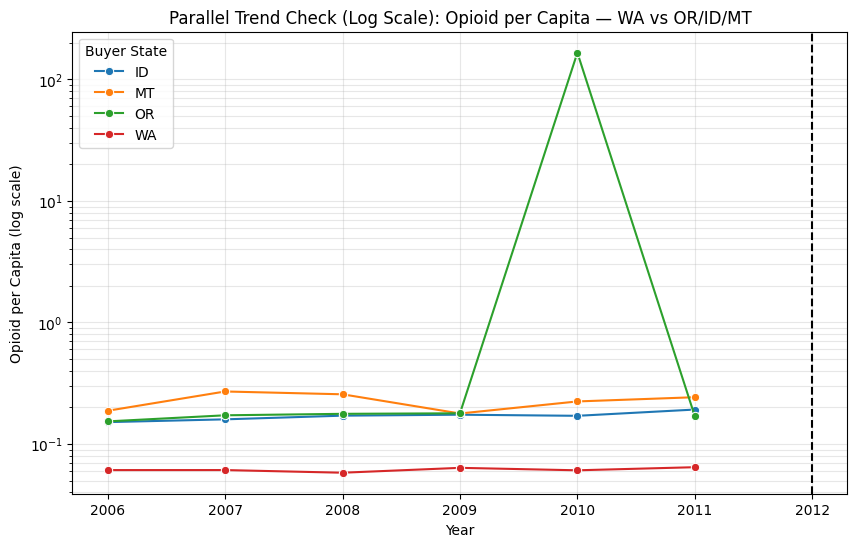

In [88]:
trend_df = (
    panel.groupby(["Buyer State", "Year"])["opioid_per_capita"]
    .mean()
    .reset_index()
)


plt.figure(figsize=(10,6))
sns.lineplot(
    data=trend_df,
    x="Year",
    y="opioid_per_capita",
    hue="Buyer State",
    marker="o"
)
plt.yscale("log")
plt.axvline(2012, color="black", linestyle="--")
plt.title("Parallel Trend Check (Log Scale): Opioid per Capita — WA vs OR/ID/MT")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita (log scale)")
plt.grid(True, which="both", alpha=0.3)
plt.show()


On the log scale, Washington’s opioid-per-capita levels are far lower and much flatter than OR/ID/MT, while Oregon shows a huge 2010 spike. Because Washington’s pre-policy trend and baseline levels differ sharply from all comparison states.

In [89]:
states_wo_or = ["WA", "ID", "MT"]

panel_wo_or = final_merged_data[
    (final_merged_data["Buyer State"].isin(states_wo_or)) &
    (final_merged_data["Year"].between(2006, 2011))
].copy()

panel_wo_or["opioid_per_capita"] = (
    panel_wo_or["Total_MME"] / panel_wo_or["Population"]
)

trend_wo_or = (
    panel_wo_or.groupby(["Buyer State", "Year"])["opioid_per_capita"]
    .mean()
    .reset_index()
)

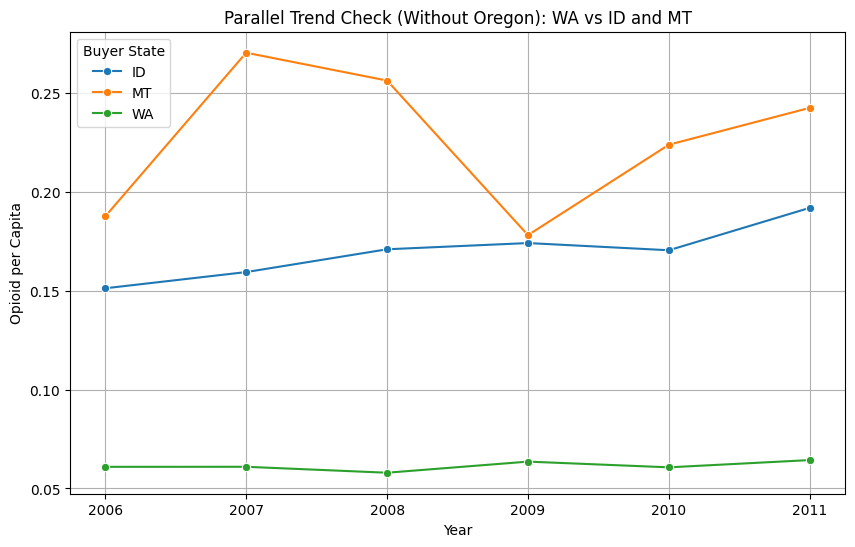

In [90]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=trend_wo_or,
    x="Year",
    y="opioid_per_capita",
    hue="Buyer State",
    marker="o"
)

plt.title("Parallel Trend Check (Without Oregon): WA vs ID and MT")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True)
plt.show()


After removing Oregon, the pre-policy trends for WA, ID, and MT still do not run parallel. Washington’s opioid-per-capita level is much lower and follows a flatter slope, while ID and especially MT have steeper and more volatile changes. This indicates the parallel trends assumption still fails, even without Oregon.

In [93]:
# Plot individual states with WA

def plot_pair(state):
    df_pair = final_merged_data[
        (final_merged_data["Buyer State"].isin(["WA", state])) &
        (final_merged_data["Year"].between(2006, 2011))
    ].copy()

    df_pair["opioid_per_capita"] = (
        df_pair["Total_MME"] / df_pair["Population"]
    )

    trend_pair = (
        df_pair.groupby(["Buyer State", "Year"])["opioid_per_capita"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=trend_pair,
        x="Year",
        y="opioid_per_capita",
        hue="Buyer State",
        marker="o"
    )
    plt.xlabel("Year")
    plt.ylabel("Opioid per Capita")
    plt.title(f"Parallel Trend Check: WA vs {state}")
    plt.grid(True)
    plt.show()


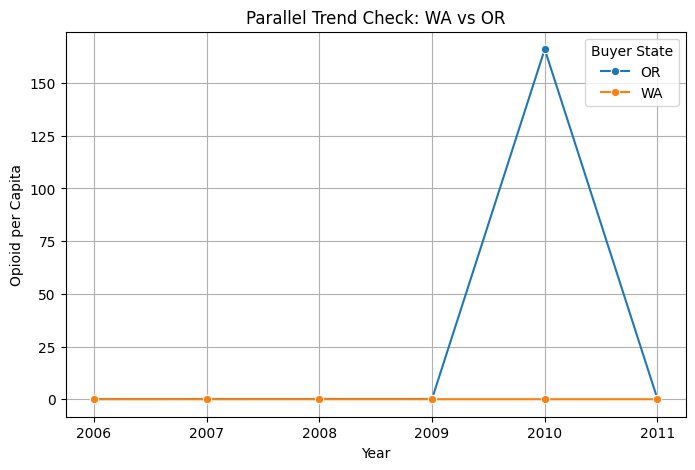

In [94]:
plot_pair("OR")

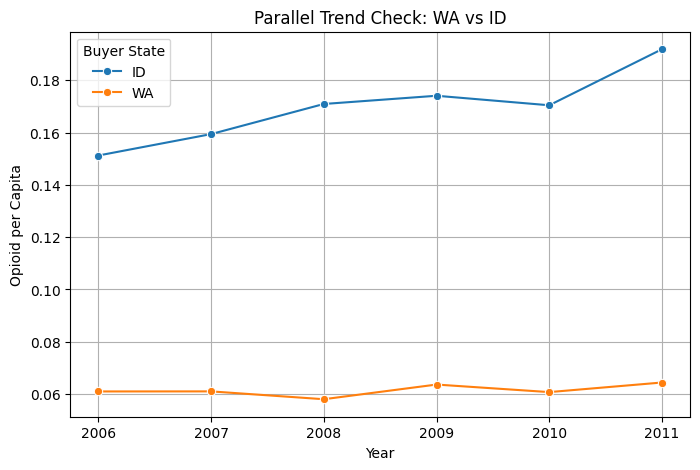

In [95]:
plot_pair("ID")

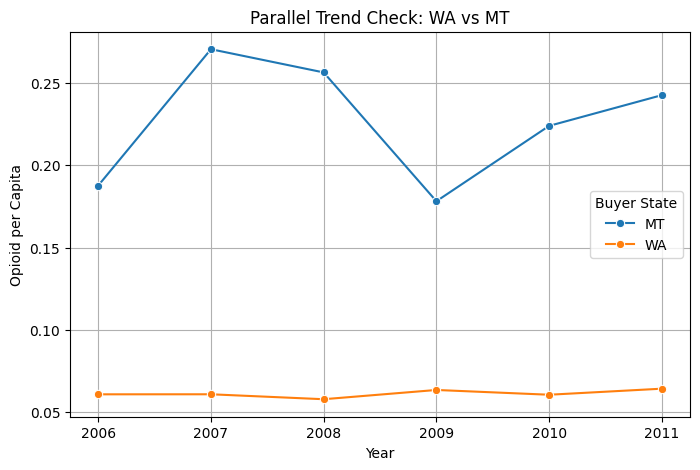

In [96]:
plot_pair("MT")

### Difference-in-Differences (DID) for Washington’s 2012 Opioid Regulation

Outcome: opioid_per_capita = Total_MME / Population

Treatment group: Washington (WA)

Control group: Oregon (OR), Idaho (ID), Montana (MT)

Pre-policy period: 2006–2011

Post-policy period: 2012–2014

In [97]:
did_states = ["WA", "OR", "ID", "MT"]

did_panel = final_merged_data[
    (final_merged_data["Buyer State"].isin(did_states)) &
    (final_merged_data["Year"].between(2006, 2014))
].copy()

# Outcome variable
did_panel["opioid_per_capita"] = did_panel["Total_MME"] / did_panel["Population"]

# DID variables
did_panel["treated"] = (did_panel["Buyer State"] == "WA").astype(int)
did_panel["post"] = (did_panel["Year"] >= 2012).astype(int)


### Main DID model — WA vs ALL controls combined

In [103]:
import statsmodels.formula.api as smf


did_all = smf.ols(
    "opioid_per_capita ~ treated*post + C(Q('Buyer State')) + C(Year)",
    data=did_panel
).fit(cov_type="cluster", cov_kwds={"groups": did_panel["Buyer State"]})

print(did_all.summary())


                            OLS Regression Results                            
Dep. Variable:      opioid_per_capita   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.213
Date:                Mon, 01 Dec 2025   Prob (F-statistic):              0.134
Time:                        19:33:12   Log-Likelihood:                -42660.
No. Observations:                5973   AIC:                         8.535e+04
Df Residuals:                    5960   BIC:                         8.543e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\sejal\miniforge3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 3
  warnings.warn('covariance of constraints does not have full '


Estimate Washington’s 2012 opioid-prescribing regulation effect relative to ID, MT, and OR.



In [104]:
did_all.params.filter(like="treated:post")

treated:post    38.545077
dtype: float64

In [105]:
did_all.pvalues["treated:post"]


0.0003247769154782795

Interpret again

In [109]:
# WA vs IDAHO

pair_ID = did_panel[did_panel["Buyer State"].isin(["WA", "ID"])].copy()

did_ID = smf.ols(
    "opioid_per_capita ~ treated*post + C(Q('Buyer State')) + C(Year)",
    data=pair_ID
).fit(cov_type="cluster", cov_kwds={"groups": pair_ID["Buyer State"]})

did_ID.params["treated:post"], did_ID.pvalues["treated:post"]


(-0.04620501398971531, 0.0)

After 2012, Washington’s opioid shipments per capita fell by 0.044 units more than Idaho’s.

This decrease is statistically significant (p < 0.001), indicating strong evidence of a policy-associated reduction in opioid shipments when Washington is compared to Idaho.

In [110]:
# WA vs Montana

pair_MT = did_panel[did_panel["Buyer State"].isin(["WA", "MT"])].copy()

did_MT = smf.ols(
    "opioid_per_capita ~ treated*post + C(Q('Buyer State')) + C(Year)",
    data=pair_MT
).fit(cov_type="cluster", cov_kwds={"groups": pair_MT["Buyer State"]})

did_MT.params["treated:post"], did_MT.pvalues["treated:post"]


(-0.04288863845019242, 0.0)

Interpret again

In [111]:
pair_OR = did_panel[did_panel["Buyer State"].isin(["WA", "OR"])].copy()

did_OR = smf.ols(
    "opioid_per_capita ~ treated*post + C(Q('Buyer State')) + C(Year)",
    data=pair_OR
).fit(cov_type="cluster", cov_kwds={"groups": pair_OR["Buyer State"]})

did_OR.params["treated:post"], did_OR.pvalues["treated:post"]


(49.17627115471835, 1.8404289954461776e-49)

The DID estimate suggests that Washington’s opioid shipments per capita increased by 49 units more than Oregon after the policy.
Although statistically significant, this result is not reliable.

> Oregon has a massive ARCOS outlier in 2010, producing extreme opioid_per_capita values for small counties, violating the DID parallel trends assumption.

> The WA–OR estimate is not credible and should be excluded from causal interpretation because Oregon’s pre-policy shipment spike violates DID parallel trends.

### Parallel Trend Check: Overdose Death Rate (2006–2009 Pre-period)

In [113]:
states_overdose = ["WA", "OR", "ID", "MT"]

panel_deaths = final_merged_data[
    (final_merged_data["Buyer State"].isin(states_overdose)) &
    (final_merged_data["Year"] >= 2006) &
    (final_merged_data["Year"] <= 2009)
][["County Code", "Buyer State", "County", "Year", "Population", "Deaths"]].copy()

# ensure numeric
panel_deaths["Deaths"] = pd.to_numeric(panel_deaths["Deaths"], errors="coerce")
panel_deaths["Population"] = pd.to_numeric(panel_deaths["Population"], errors="coerce")

# compute death rate per 100k
panel_deaths["death_rate_per_100k"] = (
    panel_deaths["Deaths"] / panel_deaths["Population"] * 100000
)

# create treated indicator (Washington = 1) for DiD comparisons
panel_deaths["treated"] = (panel_deaths["Buyer State"] == "WA").astype(int)


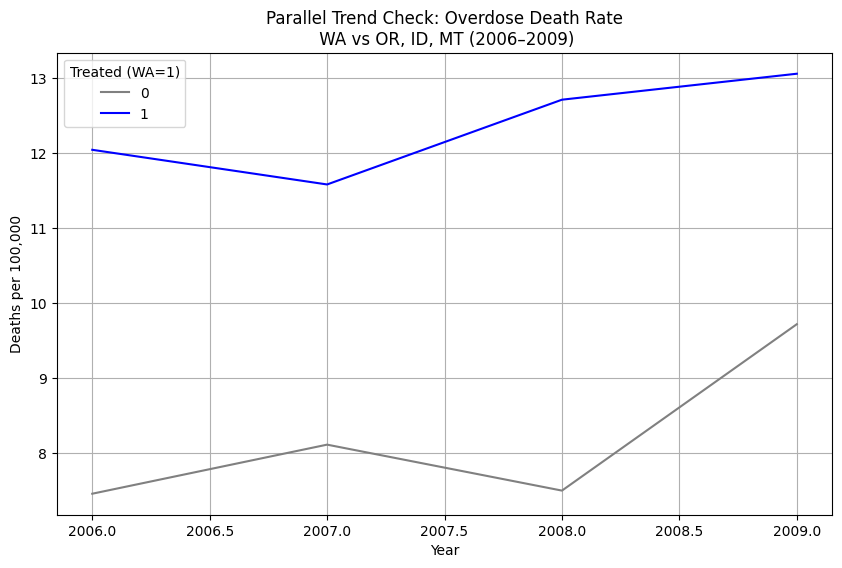

In [114]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=panel_deaths,
    x="Year",
    y="death_rate_per_100k",
    hue="treated",
    palette={1:"blue", 0:"gray"},
    estimator="mean",
    errorbar=None
)

plt.title("Parallel Trend Check: Overdose Death Rate\n WA vs OR, ID, MT (2006–2009)")
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.legend(title="Treated (WA=1)")
plt.grid(True)
plt.show()


The combined control group (OR + ID + MT) satisfies the parallel trends assumption relative to Washington for overdose death rates.